code: https://github.com/MorvanZhou/tutorials/tree/master/tensorflowTUT
playlist: https://www.youtube.com/playlist?list=PLXO45tsB95cJHXaDKpbwr5fC_CCYylw1f
https://www.tensorflow.org/versions/r0.9/tutorials/mnist/beginners/index.html
Video for this notebook


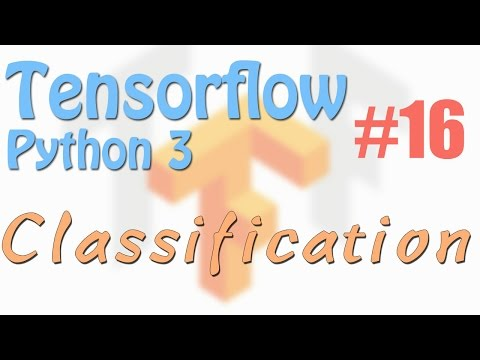

In [1]:
from IPython.display import YouTubeVideo
print ("code: https://github.com/MorvanZhou/tutorials/tree/master/tensorflowTUT")
print ("playlist: https://www.youtube.com/playlist?list=PLXO45tsB95cJHXaDKpbwr5fC_CCYylw1f")
print ("https://www.tensorflow.org/versions/r0.9/tutorials/mnist/beginners/index.html")
print "Video for this notebook"
YouTubeVideo('AhC6r4cwtq0')

In [2]:
import tensorflow as tf
import pandas as pd
import sys
import tqdm
if 'seaborn' not in sys.modules:
    %pylab inline
    import seaborn
tf.reset_default_graph()
sess = tf.InteractiveSession()

Populating the interactive namespace from numpy and matplotlib


# Load MNIST data

The MNIST data is another typical Machine Learning test dataset, this time leasrning to classify multiple possible images which are the handwritten digits 0-9 .

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


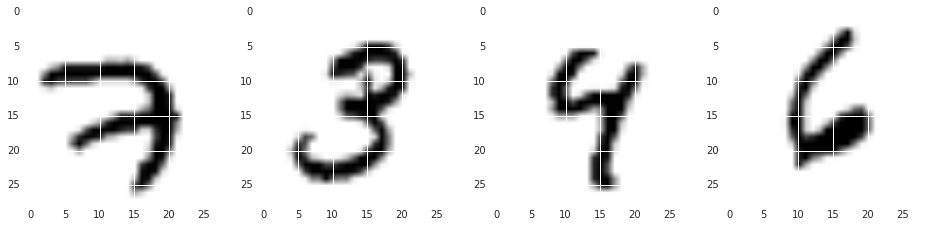

In [4]:
def raster(id_square):
    """Assume it's a square, fill a 2d grid for imshow
    """
    ret = []
    rl = int(sqrt(len(id_square)))
    for i in range(rl):
        ret.append(list(id_square[i*rl:(i+1)*rl]))
    return ret

f = plt.figure(figsize=(16,4))
for i in range(4):
    ax = f.add_subplot(1,4,i+1)
    ax.imshow(raster(mnist.train.images[i]))

# Let's see how well I can classify with a pure probabalistic model

In [5]:
print ("One-hot encoding for labels in this dataset")
print (mnist.train.labels)

One-hot encoding for labels in this dataset
[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]


In [31]:
# Looks like the images are filled with numbers between zero and one here
print len(mnist.train.images[0]), mnist.train.images[0].mean(), mnist.train.images[0].min(), mnist.train.images[0].max()

784 0.154417 0.0 0.996078


9 0


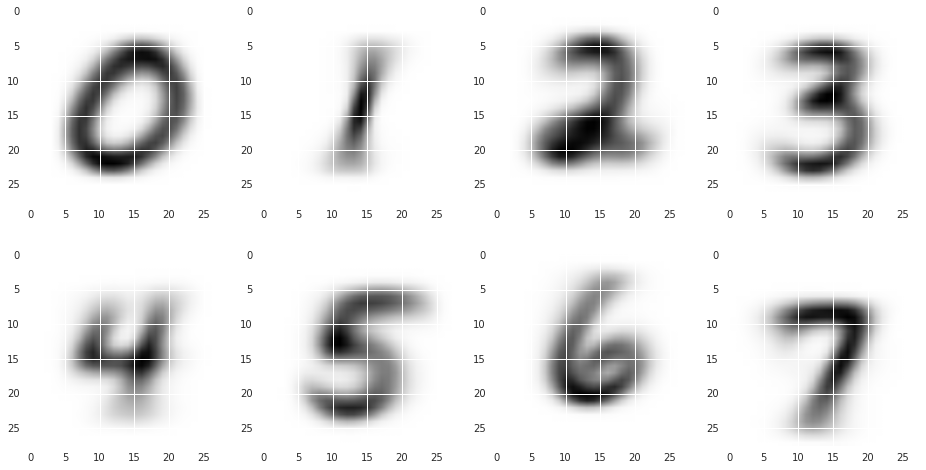

In [21]:
# sort, sum, normalize
f = plt.figure(figsize=(16,4))
sim = {}
nim = {}
numberlabels = [l.tolist().index(1) for l in mnist.train.labels]
print max(numberlabels), min(numberlabels)
for im, l in zip(mnist.train.images, numberlabels):
    try:
        sim[l] = sim[l] + im
        nim[l] = nim[l] + 1.
    except KeyError:
        sim[l] = im
        nim[l] = 1.
        
f = plt.figure(figsize=(16,8))
for i in range(8):
    ax = f.add_subplot(2,4,i+1)
    ax.imshow(raster(sim[i]/nim[i]))

In [32]:
def calcprob(imagea, imagep):
    return sum(imagea * imagep + (1 - imagea) * (1- imagep))
    for ia, ip in zip(imagea, imagep):
        # branch 1 v        branch 0 v
        p = p + ip * ia + (1 - ia) * (1 - ip)

In [52]:
def predict(imagea, sim=sim, nim=nim):
    probs = [calcprob(imagea, sim[i]/nim[i]) for i in range(10)]
    return probs.index(max(probs))

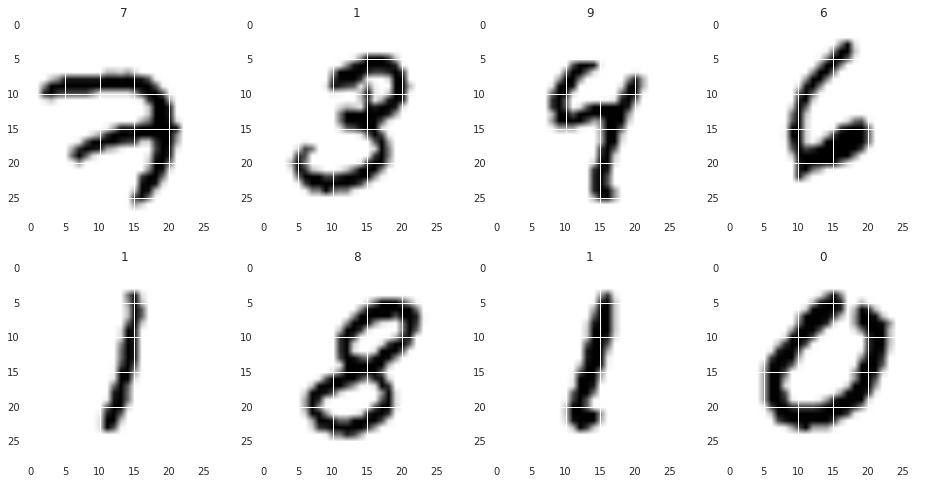

In [53]:
f = plt.figure(figsize=(16,8))
for i in range(8):
    pr = predict(mnist.train.images[i])
    ax = f.add_subplot(2,4,i+1)
    ax.set_title(str(pr))
    ax.imshow(raster(mnist.train.images[i]))

In [56]:
# Test set
def calc_correct(images, labels, function):
    correct = 0
    numberlabels = [l.tolist().index(1) for l in labels]
    return sum([function(im)==lab for im,lab in zip(images, numberlabels)])/float(len(labels))

In [57]:
calc_correct(mnist.test.images, mnist.test.labels, predict)

0.55869999999999997

In [58]:
# Out of 10 possible labels, I label correctly 56% of the time with a pure probablistic approach, 
# not including any cell-to-cell correlations, this is pretty good already, I could probably identify other key shapes
# to boost this, and/or by looking at coarse clustering/other pattern recognition

# Create some variables and the classifier

In [118]:
summaries = []
with tf.name_scope('fit_parameters'):
    W = tf.Variable(tf.zeros([784, 10]), name = 'pixel_weights')
    b = tf.Variable(tf.zeros([10]), 'prob_offsets')
    summaries.append(tf.scalar_summary("w0", W[0][0]))
    summaries.append(tf.scalar_summary("prob_offsets", b[0]))

with tf.name_scope('inputs'):
    i_images = tf.placeholder(tf.float32, [None, 784], name='mnist_images')
    i_true = tf.placeholder(tf.float32, [None, 10], name='mnist_labels')

with tf.name_scope('training'):
    #
    # model assumes that there is some linear relationship
    # between pixel occupancy, correlations between those,
    # and category at this stage
    model = tf.nn.softmax(tf.matmul(i_images, W) + b)
    # Cross entropy for penalty, how well does the true value 
    # get identified, independent of the other values
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(i_true * tf.log(model), reduction_indices=[1]))
    penalty = cross_entropy
    summaries.append(tf.scalar_summary("cross_entropy", penalty))
    optimizer = tf.train.GradientDescentOptimizer(0.5)
    train = optimizer.minimize(penalty)

In [119]:
# Train it ...

In [120]:
writer = tf.train.SummaryWriter('/tmp/test/', sess.graph)

In [121]:
init = tf.initialize_all_variables()
sess.run(init)
merge_op = tf.merge_summary(summaries)

In [122]:
n_step = 250
for step in tqdm.tqdm(range(n_step)):
    batch_im, batch_true = mnist.train.next_batch(1000)
    if (25*step)%n_step!=0:
        _ = sess.run(train, feed_dict={i_images: batch_im, i_true : batch_true})
    else:
        _, ipenalty, result = sess.run([train, penalty, merge_op], feed_dict={i_images: batch_im, i_true : batch_true})
        print(ipenalty)
        writer.add_summary(result, step)

  8%|▊         | 20/250 [00:00<00:04, 48.91it/s]

2.30259
0.819881
0.547865
0.513126


 20%|██        | 51/250 [00:00<00:02, 74.29it/s]

0.529451
0.379061


 31%|███       | 77/250 [00:00<00:02, 80.13it/s]

0.414827
0.418517
0.407046
0.404613


 43%|████▎     | 108/250 [00:00<00:01, 104.37it/s]

0.39164
0.414348


 54%|█████▍    | 136/250 [00:01<00:01, 106.03it/s]

0.392495
0.374692
0.408154


 66%|██████▌   | 164/250 [00:01<00:00, 118.37it/s]

0.350812
0.32613


 76%|███████▋  | 191/250 [00:01<00:00, 104.15it/s]

0.409204
0.359316
0.328573


 88%|████████▊ | 219/250 [00:01<00:00, 119.41it/s]

0.311841
0.318747


 99%|█████████▉| 247/250 [00:02<00:00, 111.18it/s]

0.366389
0.339377
0.336289


100%|██████████| 250/250 [00:02<00:00, 113.36it/s]


# Accuracy/Efficiency

In [123]:
def create_accuracy(model):
    correct_prediction = tf.equal(tf.argmax(i_true,1), tf.argmax(model,1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [124]:
accuracy = create_accuracy(model)

In [125]:
print(sess.run(accuracy, feed_dict={i_images: mnist.test.images, i_true: mnist.test.labels}))

0.9108


# Now try DNN from scikit flow

In [127]:

import tensorflow.contrib.learn as skflow
from sklearn import datasets, metrics

In [128]:
feature_columns = skflow.infer_real_valued_columns_from_input(mnist.train.images)
print feature_columns

[_RealValuedColumn(column_name='', dimension=784, default_value=None, dtype=tf.float32, normalizer=None)]


In [129]:
category = sess.run(tf.argmax(mnist.train.labels, 1))
print category[:5]
classifier = skflow.DNNClassifier(hidden_units=[784, 784, 784], n_classes=10, feature_columns=feature_columns)

Explicitly set `enable_centered_bias` to 'True' if you want to keep existing behaviour.


[0 8 2 9 2]


In [131]:
# Running this next cell will take some time!

In [132]:
classifier.fit(mnist.train.images[:10000], category[:10000], steps=250)

Estimator(params={'enable_centered_bias': True, 'activation_fn': <function relu at 0x7f70c3937668>, 'weight_column_name': None, 'hidden_units': [784, 784, 784], 'feature_columns': [_RealValuedColumn(column_name='', dimension=784, default_value=None, dtype=tf.float32, normalizer=None)], 'n_classes': 10, 'optimizer': 'Adagrad', 'dropout': None, 'gradient_clip_norm': None, 'num_ps_replicas': 0})

In [133]:
score = metrics.accuracy_score(category[10000:20000], classifier.predict(mnist.train.images[10000:20000]))
print("Accuracy: %f" % score)

Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.
Instructions for updating:
The default behavior of predict() is changing. The default value for
as_iterable will change to True, and then the flag will be removed
altogether. The behavior of this flag is described below.


Accuracy: 0.933500
